In [ ]:
from google.colab import files
upload = files.upload()
print('File has Uploaded')

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
File has Uploaded


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
churn = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [ ]:
churn.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
print("Dataset Info:")
display(churn.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

None

In [ ]:
print("\\nMissing Values:")
display(churn.isna().sum())

\nMissing Values:


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [ ]:
print("\\nTarget Distribution:")
display(churn["Churn"].value_counts(normalize=True) * 100)

\nTarget Distribution:


,proportion
Churn,
No,73.463013
Yes,26.536987


In [ ]:
if "TotalCharges" in churn.columns:
    churn["TotalCharges"] = pd.to_numeric(churn["TotalCharges"], errors="coerce")
    print("Converted TotalCharges to numeric")

print("Missing after conversion:")
display(churn.isna().sum())

Converted TotalCharges to numeric
Missing after conversion:


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


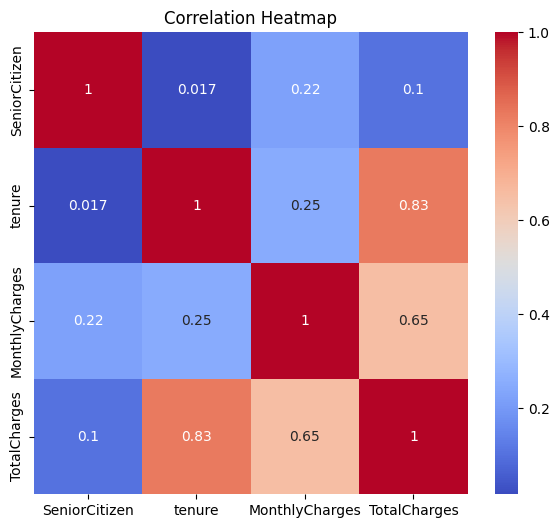

In [ ]:
numeric_cols = churn.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(7,6))
sns.heatmap(churn[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
X = churn.drop("Churn", axis=1)
y = churn["Churn"].map({"Yes": 1, "No": 0})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [ ]:
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)])

In [ ]:
rf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))])

In [ ]:
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])

In [ ]:
rf_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [6, 10],}

In [ ]:
xgb_params = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [3, 6],
    "clf__learning_rate": [0.1, 0.01]}

In [ ]:
cv = StratifiedKFold(4, shuffle=True, random_state=42)

In [ ]:
rf_search = GridSearchCV(rf_pipeline, rf_params, cv=cv, scoring="roc_auc")
rf_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('impute',...
                                                                         Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [6, 10],
                         'clf__n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
xgb_search = GridSearchCV(xgb_pipeline, xgb_params, cv=cv, scoring="roc_auc")
xgb_search.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:13] WARNING: /w

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('impute',...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'clf__learning_rate': [0.1, 0.01],
                         'clf__max_depth': [3, 6],
                         'clf__n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
print("✔ Best RF:", rf_search.best_params_)
print("✔ Best XGB:", xgb_search.best_params_)

✔ Best RF: {'clf__max_depth': 10, 'clf__n_estimators': 200}
✔ Best XGB: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}


In [ ]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"===== {name} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("\\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\\nConfusion Matrix:")
    display(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {name}")
    plt.show()

===== RandomForest =====
Accuracy: 0.7476901208244492
ROC-AUC: 0.8212619906714775
\nClassification Report:
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1033
           1       0.79      0.07      0.13       374

    accuracy                           0.75      1407
   macro avg       0.77      0.53      0.49      1407
weighted avg       0.76      0.75      0.66      1407

\nConfusion Matrix:


Predicted,0,1
Actual,,
0,1026,7
1,348,26


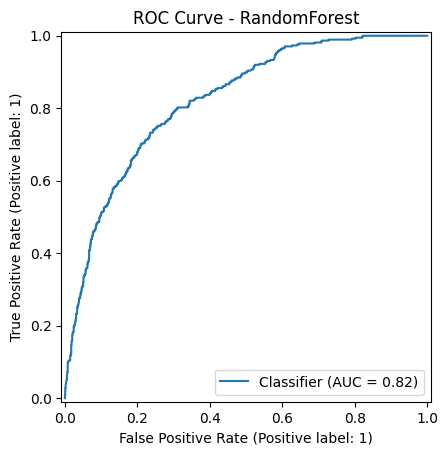

===== XGBoost =====
Accuracy: 0.7924662402274343
ROC-AUC: 0.8380566958808517
\nClassification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407

\nConfusion Matrix:


Predicted,0,1
Actual,,
0,920,113
1,179,195


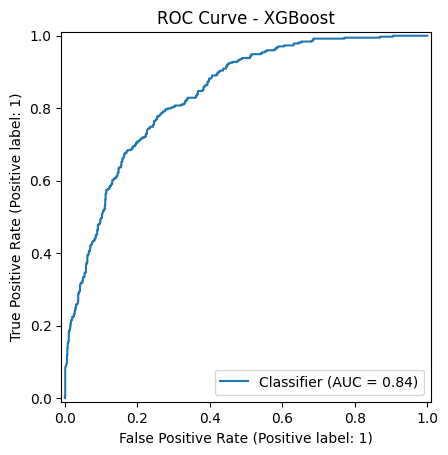

In [ ]:

best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

evaluate(best_rf, "RandomForest")
evaluate(best_xgb, "XGBoost")